In [276]:
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
df = pd.read_csv('bank-additional-full.csv', delimiter=";", quotechar="'").replace('"', value='', regex=True)

In [120]:
df.columns = df.columns.str.replace('"','')

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  object 
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [122]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [123]:
df[df.isna().any(axis=1)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


In [124]:
for col in df.columns:
    fig = plt.figure(figsize=(10, 6))
    plt.hist(x=df[col], edgecolor='black')
    plt.title(col + '\nDistinct values: ' + str(len(df[col].unique())))
    plt.savefig('plots\\' + col + '.png', dpi=300)
    plt.close()

In [125]:
cat_columns = ['job', 'marital', 'education', 'default', 'contact', 'housing', 'loan', 'day_of_week', 'month', 'poutcome']
val_columns = ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays', 'previous']

In [126]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].astype('category')

for col in val_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [128]:
df_no_onehot = df

In [129]:
df_corr = pd.get_dummies(df, drop_first=False).corr()

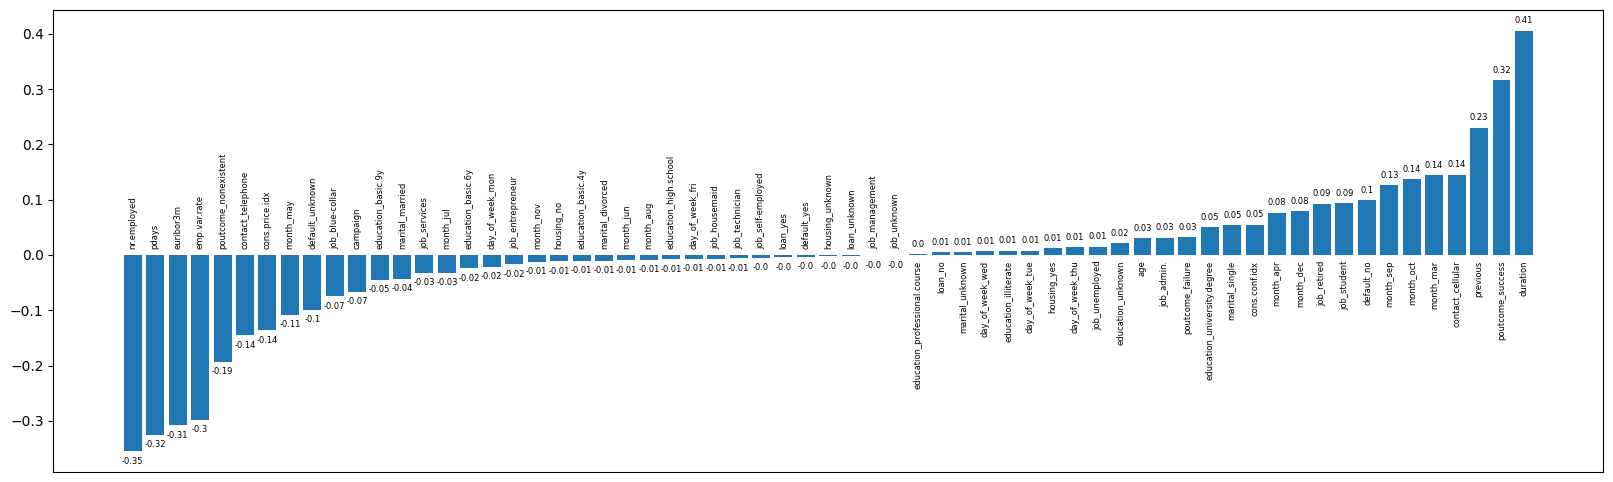

In [130]:
sorted_df = df_corr['y_yes'].sort_values()[1:-1]

plt.figure(figsize=(20, 6))

bars = plt.bar(x=sorted_df.index, height=sorted_df, width=0.8)

for idx, bar in enumerate(bars):
    yval = bar.get_height()
    cat = sorted_df.index[idx]
    if yval >= 0:
        va_val = 'bottom'
        va_val2 = 'top'
        offset = 0.01
    else:
        va_val = 'top'
        va_val2 = 'bottom'
        offset = -0.01
    plt.text(bar.get_x() + bar.get_width()/2, yval + offset, round(yval, 2), va=va_val, ha='center', fontsize=6)
    plt.text(bar.get_x() + bar.get_width()/2, 0 - offset, cat, va=va_val2, ha='center', fontsize=6, rotation=90)

plt.xticks([])
plt.savefig('plots\\correlation.png', dpi=300)
plt.show()

In [317]:
X = df_no_onehot.drop('y', axis=1)
y = df_no_onehot['y'].cat.codes

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [319]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [320]:
def train_and_predict(params, train_data, test_data):
    
    model_lgb = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])

    y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

    y_pred_binary = (y_pred >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)

    return (accuracy, roc_auc, y_test, y_pred)

In [ ]:
stats = []

for leaves in range(2, 30):
    for learning in range(10, 250, 10):
        params = {
            'objective': 'binary',
            'is_unbalance': True,
            'metric': 'binary_logloss',
            'learning_rate': learning/1000,
            'num_leaves': leaves,
        }

        acc, roc, y_test, y_pred = train_and_predict(params, train_data, test_data)

        stats.append([leaves, learning, acc, roc])


In [202]:
s1 = pd.DataFrame(stats.copy())
s1.columns = ['num_leaves', 'learning_rate', 'accuracy', 'roc']
s1['learning_rate'] = s1['learning_rate'] / 1000

In [236]:
s1.sort_values('accuracy', ascending=False).head()

,num_leaves,learning_rate,accuracy,roc
420,19,0.13,0.913207,0.942890
396,18,0.13,0.912236,0.940915
272,13,0.09,0.912115,0.938521
442,20,0.11,0.911872,0.942308
590,26,0.15,0.910415,0.943100


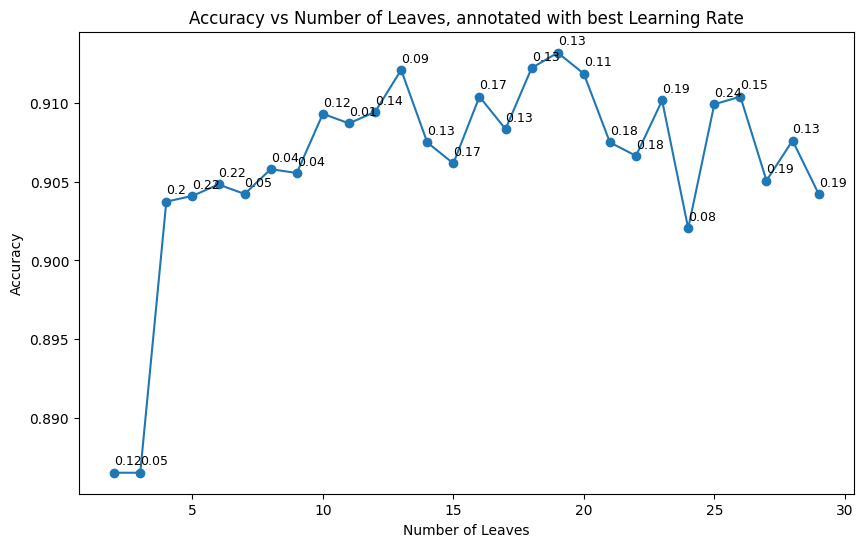

In [343]:
stats_leaves_sorted = s1.sort_values('accuracy', ascending=False).drop_duplicates(subset=['num_leaves'], keep='first').sort_values('num_leaves', ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(stats_leaves_sorted['num_leaves'], stats_leaves_sorted['accuracy'], marker='o')
for index, row in stats_leaves_sorted.iterrows():
    plt.text(row['num_leaves'], row['accuracy'] + 0.0005, str(row['learning_rate']), fontsize=9, )
plt.title('Accuracy vs Number of Leaves, annotated with best Learning Rate')
plt.xlabel('Number of Leaves')
plt.ylabel('Accuracy')
plt.savefig('plots\\acc_vs_num_leaves.png', dpi=300)
plt.show()

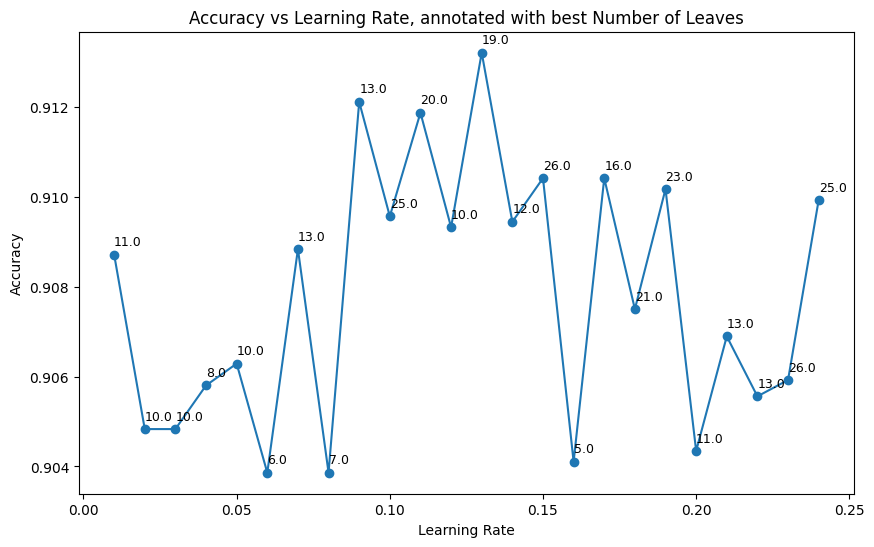

In [344]:
stats_learning_rate_sorted = s1.sort_values('accuracy', ascending=False).drop_duplicates(subset=['learning_rate'], keep='first').sort_values('learning_rate', ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(stats_learning_rate_sorted['learning_rate'], stats_learning_rate_sorted['accuracy'], marker='o')
for index, row in stats_learning_rate_sorted.iterrows():
    plt.text(row['learning_rate'], row['accuracy'] + 0.0002, str(row['num_leaves']), fontsize=9, )
plt.title('Accuracy vs Learning Rate, annotated with best Number of Leaves')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.savefig('plots\\acc_vs_learning_rate.png', dpi=300)
plt.show()

In [325]:
params = {
    'objective': 'binary',
    'is_unbalance': True,
    'metric': 'binary_logloss',
    'learning_rate': 0.13,
    'num_leaves': 19,
}

acc, roc, y_test, y_pred = train_and_predict(params, train_data, test_data)

print("\n\nAccuracy:",acc, "\n\nROC:", roc, "\n\nClassification report:\n", classification_report(y_test, (y_pred >= 0.5).astype(int)))

[LightGBM] [Info] Number of positive: 3705, number of negative: 29245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112443 -> initscore=-2.066025
[LightGBM] [Info] Start training from score -2.066025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.242772	valid_1's binary_logloss: 0.249241


Accuracy: 0.9132070890992959 

ROC: 0.9428904391353345 

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      7303
           1       0.61      0.67      0.64       935

    accuracy              

In [329]:
df_onehot = pd.get_dummies(df_no_onehot)
df_onehot['y'] = df_onehot['y_yes']
df_onehot = df_onehot.drop(['y_yes', 'y_no'], axis=1)

In [330]:
X = df_onehot.drop(['y'], axis=1)
y = df_onehot['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [332]:
stats = []
for est in range(50, 500, 5):
    rfc = RandomForestClassifier(n_estimators=est, random_state=99)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    stats.append([est, accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])

In [333]:
s2 = pd.DataFrame(stats)
s2.columns = ['estimators', 'accuracy', 'roc']

In [334]:
s2.sort_values('accuracy', ascending=False).head()

,estimators,accuracy,roc
48,290,0.915028,0.728253
56,330,0.914785,0.727184
47,285,0.914785,0.728116
49,295,0.914664,0.728514
43,265,0.914542,0.726580


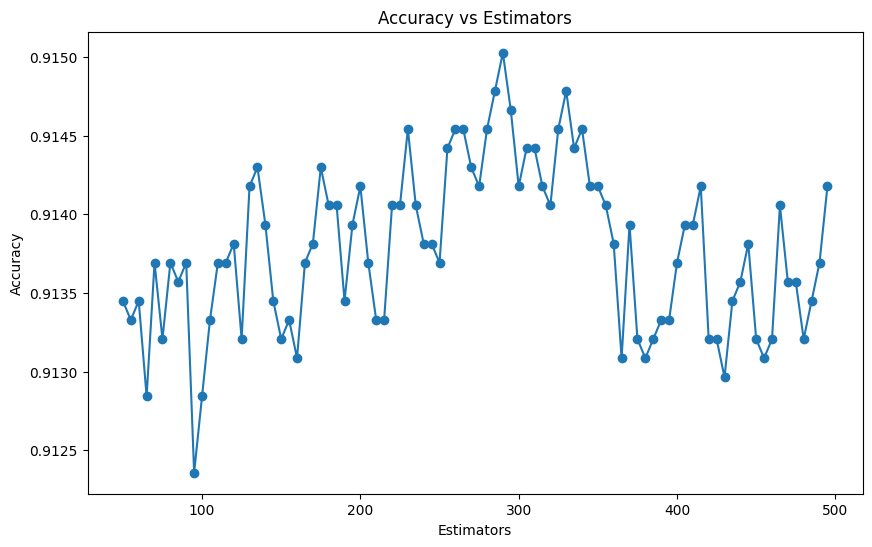

In [345]:
plt.figure(figsize=(10, 6))
plt.plot(s2['estimators'], s2['accuracy'], marker='o')
plt.title('Accuracy vs Estimators')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.savefig('plots\\acc_vs_estimators.png', dpi=300)
plt.show()

In [336]:
rfc = RandomForestClassifier(n_estimators=290, random_state=99)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("\n\nAccuracy:", accuracy_score(y_test, y_pred), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9150279193979121 

ROC: 0.7282532048583067 

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.67      0.49      0.57       935

    accuracy                           0.92      8238
   macro avg       0.81      0.73      0.76      8238
weighted avg       0.91      0.92      0.91      8238

